Artificial Neural Network - Mini Project

1. Car Object Detection using (ConvNet/CNN) Neural Network
2. Car Object Data: Data Source – https://www.kaggle.com/datasets/sshikamaru/car-object-detection
3. The dataset contains images of cars in all views.
4. Training Images – Set of 1000 files
5. Use Tensorflow, Keras & Residual Network resNet50
6. Constructs comparative outputs for various Optimisation algorithms and finds out good accuracy.

# Importing Libraries

In [39]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

from pathlib import Path

# Reading Images

In [27]:
train_path = Path('C:/Users/darsh/Desktop/DS Codes/archive/data/training_images')
test_path = Path('C:/Users/darsh/Desktop/DS Codes/archive/data/testing_images')

In [29]:
train = pd.read_csv('C:/Users/darsh/Desktop/DS Codes/archive/data/train_solution_bounding_boxes (1).csv')
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

**Displaying Image**

In [30]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)
    

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])
            

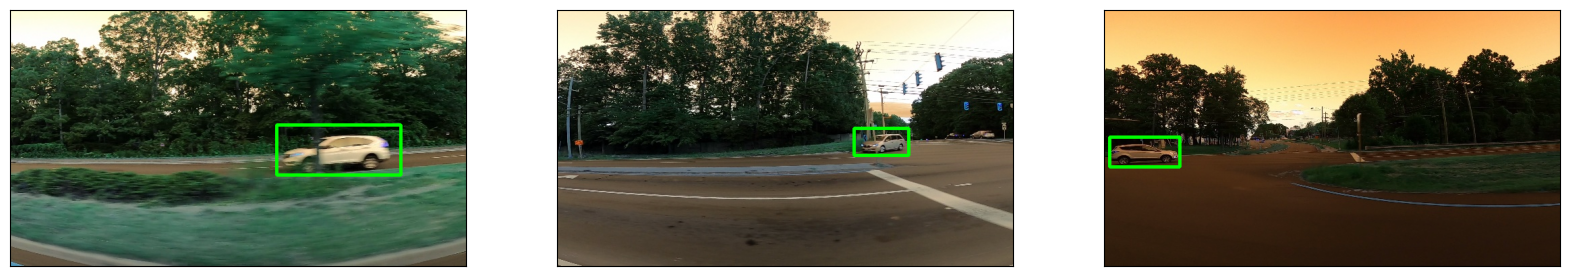

In [31]:
display_grid()

**Model Training**

In [32]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}

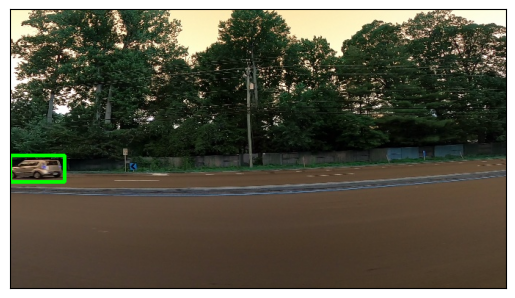

In [33]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

# models architecture:



In [34]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 380, 676, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 380, 676, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 380, 676, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 190, 338, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 190, 338, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 190, 338, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 95, 169, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 95, 169, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 95, 169, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 101,761,236 (388.19 MB)

 Trainable params: 101,744,868 (388.13 MB)

 Non-trainable params: 16,368 (63.94 KB)

In [35]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

# Testing data

In [36]:
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


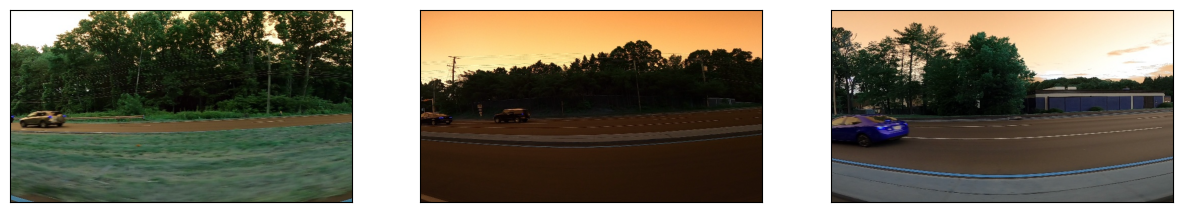

In [37]:
test(model)

The model hvaent been trained yet, thats why the predictions arent even visible yet

Epoch 1/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4658 - loss: 42458.253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


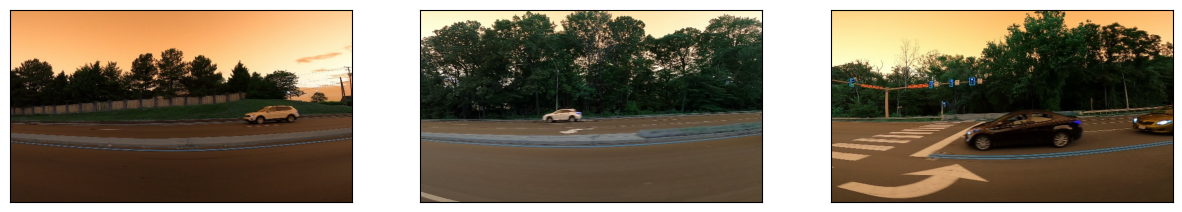

50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4667 - loss: 42130.5781
Epoch 2/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6414 - loss: 10621.332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


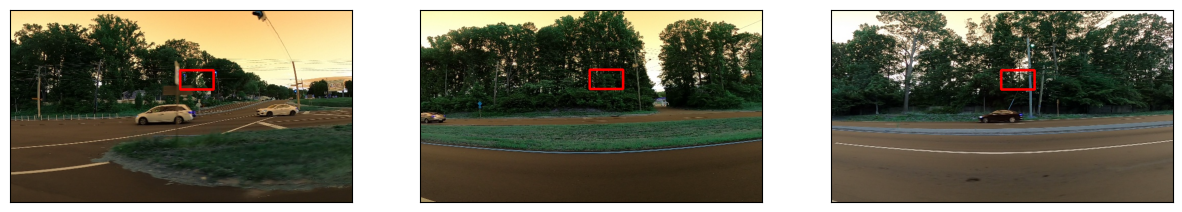

50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6432 - loss: 10565.9170
Epoch 3/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9144 - loss: 4372.960
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


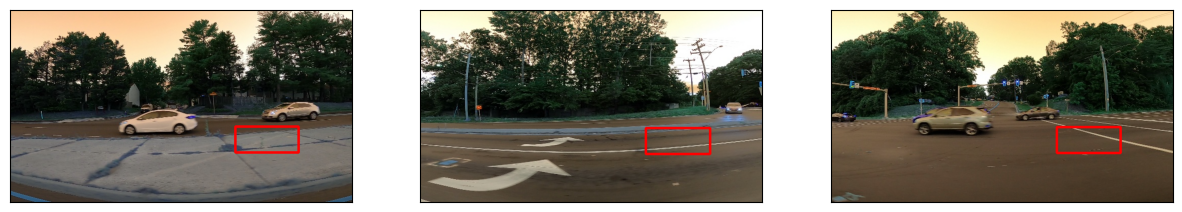

50/50 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.9141 - loss: 4368.3154
Epoch 4/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9415 - loss: 2232.887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


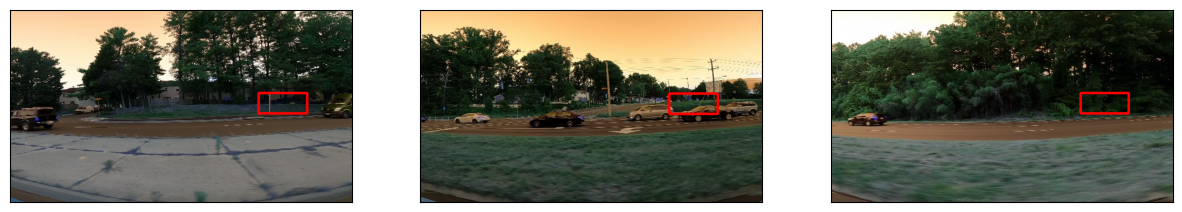

50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9415 - loss: 2232.2446
Epoch 5/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9602 - loss: 1376.380
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


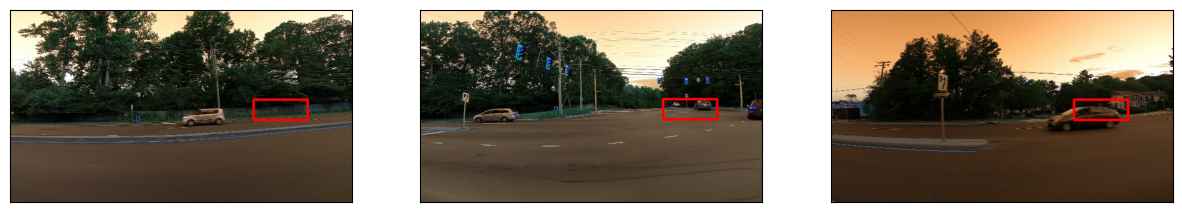

50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9601 - loss: 1381.7715
Epoch 6/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9339 - loss: 1887.293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


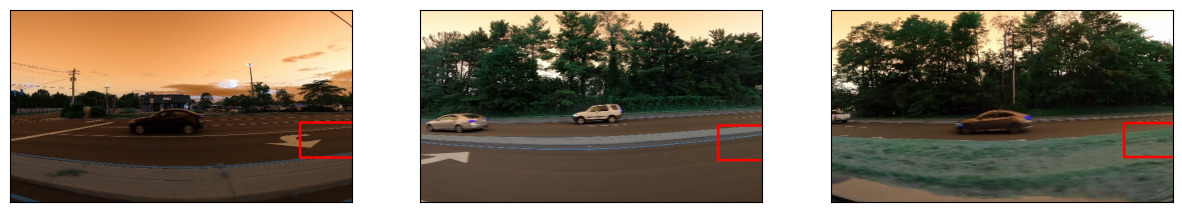

50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9339 - loss: 1893.2896
Epoch 7/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9344 - loss: 1915.376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


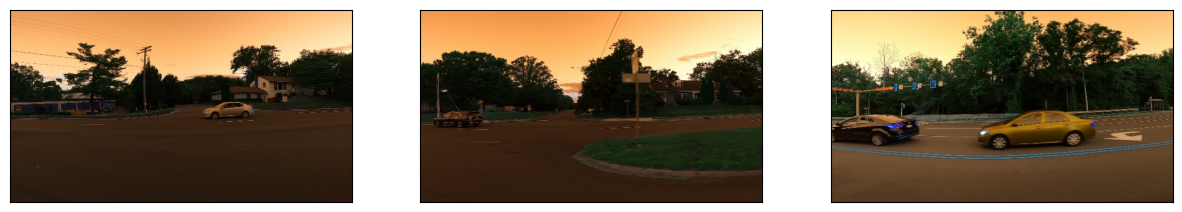

50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9347 - loss: 1912.9984
Epoch 8/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9480 - loss: 1417.972
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


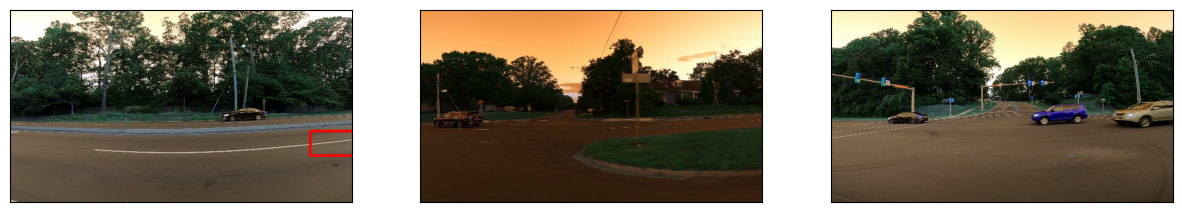

50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9482 - loss: 1415.4402
Epoch 9/9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9613 - loss: 1793.156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


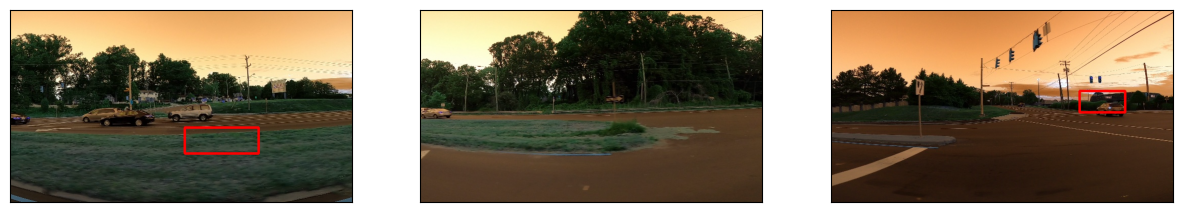

50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9613 - loss: 1788.7505


In [38]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=50,
        callbacks=[
            ShowTestImages(),
        ]
    )